# Prediction using Supervised ML(Level-Beginner)

Task: To predict the percentage of marks of an student based on the number of study hours by using a simple linear regression as it involves two variables. The data can be found at https://raw.githubusercontent.com/AdiPersonalWorks/Random/master/student_scores%20-%20student_scores.csv

Question: What will be predicted score if a student studies for 9.25 hrs/ day?

In [1]:
#for data
import pandas as pd
import numpy as np

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

#for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics,decomposition

#for explainer
from lime import lime_tabular

To read data into a pandas Dataframe. 
The original dataset caotain two columns and adding the Id column for this tutorial.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/AdiPersonalWorks/Random/master/student_scores%20-%20student_scores.csv")
df.reset_index(inplace=True)
df.rename(columns={'index': 'Id'}, inplace=True)
df.head()

,Id,Hours,Scores
0,0,2.5,21
1,1,5.1,47
2,2,3.2,27
3,3,8.5,75
4,4,3.5,30


## Data Analysis

#### Recognize whether a column is numerical or categorical
The exploratory data analysis is to summarize the main characteristics of a dataset to understand what the data can tell beyond the formal modeling or hypothesis testing task.

In [3]:
def utils_recognize_type(df, col, max_cat=20):
    if (df[col].dtypes == int) |(df[col].nunique() < max_cat):
        return 'cat'
    else:
        return 'num'

For several occasions with the real world datasets, there are many missing data. This function is to give an illustration of a heatmap of the dataframe and visualize columns to check type and missing data. Scores is the dependent variable which need to be predict.

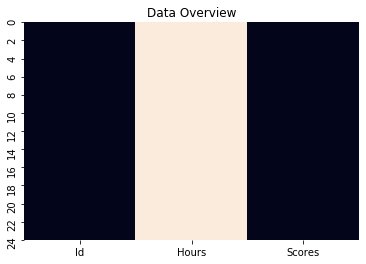

 Categoricial  Numeric  NaN


In [4]:
dic_cols = {col:utils_recognize_type(df, col, max_cat=20) for col in df.columns}

heatmap = df.isnull()
for k, v in dic_cols.items():
    if v == 'num':
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

sns.heatmap(heatmap, cbar=False).set_title('Data Overview')
plt.show()

print("\033[1;37;40m Categoricial", "\033[1;30;41m Numeric", "\033[1;30;47m NaN")

The univariate distributions(probability distribution of one variable).
A histogram is to give a rough sense of density of the underlying distribution of a single numerical data.
A box plot imply data groups through their quartiles.

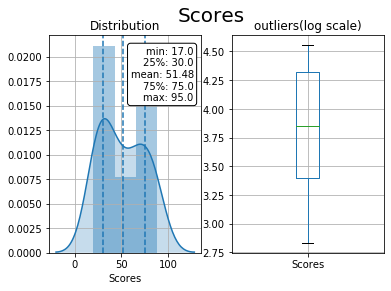

In [5]:
x = "Scores"

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)

## Distribution
ax[0].title.set_text('Distribution')
variable = df[x].fillna(df[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ]

sns.distplot(variable, hist=True, kde=True, kde_kws={'shade': True}, ax=ax[0])
des = df[x].describe()
ax[0].axvline(des['25%'], ls='--')
ax[0].axvline(des['mean'], ls='--')
ax[0].axvline(des['75%'], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(('min: '+des['min'], '25%: '+des['25%'], 
                 'mean: '+des['mean'], '75%: '+des['75%'], 'max: '+des['max']))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, 
          va='top', ha='right', bbox=dict(boxstyle='round', facecolor='white', alpha=1))

## Boxplot
ax[1].title.set_text('outliers(log scale)')
tmp_df = pd.DataFrame(df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])
plt.show()


/Users/gympohnpimol/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/gympohnpimol/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


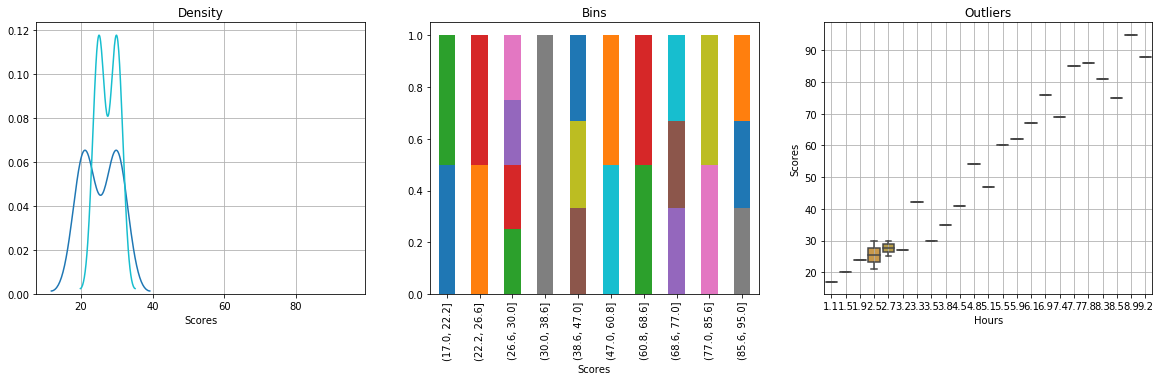

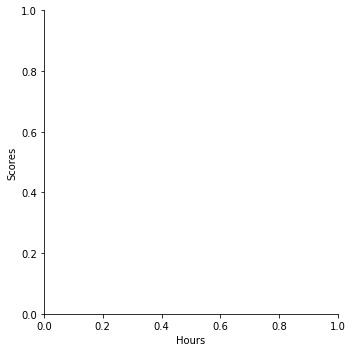

In [6]:
cat, num = 'Hours', 'Scores'

fix, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(20,5))
fig.suptitle('Hours vs Scores', fontsize=20)

## Distribution
ax[0].title.set_text('Density')
for i in df[cat].unique():
    sns.distplot(df[df[cat]==i][num], hist=False, ax=ax[0])
ax[0].grid(True)

## Stacked
ax[1].title.set_text('Bins')
breaks = np.quantile(df[num], q=np.linspace(0, 1, 11))
tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
tmp['tot'] = tmp.sum(axis=1)
for col in tmp.drop('tot', axis=1).columns:
    tmp[col] = tmp[col]/tmp['tot']
tmp.drop('tot', axis=1).plot(kind='bar', stacked=True, ax=ax[1],
                            legend=False, grid=False)

## Boxplot
ax[2].title.set_text('Outliers')
sns.catplot(x=cat, y=num, data=df, kind='box', ax=ax[2])
ax[2].grid(True)
plt.show()

Grouping "Hours" values into bins and compare the mean and median of "Scores" in each bins. 
The scatter plot depict the distributions of the two variables on the sides.

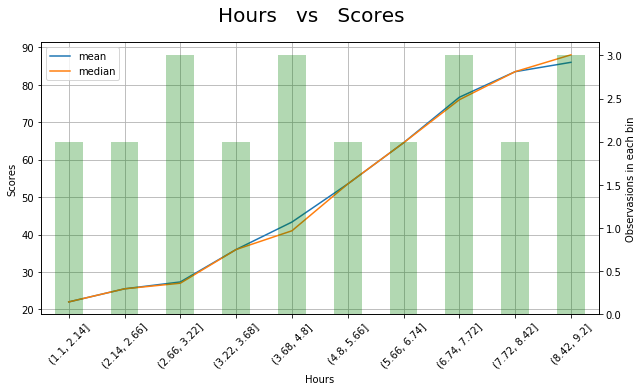

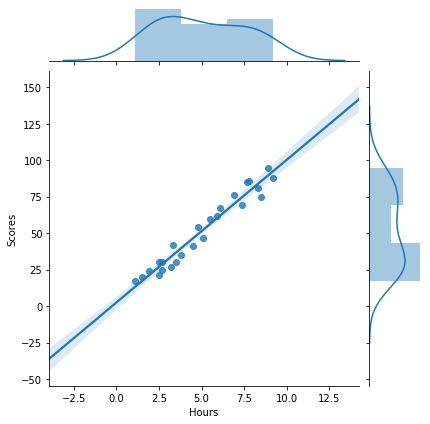

In [7]:
x, y = 'Hours', 'Scores'

## Bin plot
df_noNan = df[df[x].notnull()]
breaks = np.quantile(df_noNan[x], q=np.linspace(0, 1, 11))
groups = df_noNan.groupby([pd.cut(df_noNan[x], bins=breaks,
                         duplicates='drop')])[y].agg(['mean', 'median', 'size'])
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle(x+'   vs   '+y, fontsize=20)
groups[['mean', 'median']].plot(kind='line', ax=ax)
groups['size'].plot(kind='bar', ax=ax, rot=45, secondary_y=True,
                   color='green', alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel('Observasions in each bin')
plt.show()

## Scatter plot
sns.jointplot(x=x, y=y, data=df, dropna=True, kind='reg')
plt.show()

## Preprocessing 

Data preprocessing is the phase of preparing raw data to make it suitable for a machine learning model.

In [8]:
## split data
df = df.drop('Id', axis=1)
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

## print info
print("X_train shape:", df_train.drop("Scores",axis=1).shape, "| X_test shape:", df_test.drop("Scores",axis=1).shape)
print("y_train mean:", round(np.mean(df_train["Scores"]),2), "| y_test mean:", round(np.mean(df_test["Scores"]),2))
print(df_train.shape[1], "features:", df_train.drop("Scores",axis=1).columns.to_list())

## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(df_train.drop('Scores', axis=1))

df_scaled = pd.DataFrame(X, columns=df_train.drop('Scores', axis=1).columns, index=df_train.index)

## scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
df_scaled[y] = scalerY.fit_transform(df_train[y].values.reshape(-1, 1))
df_scaled.head()

X_train shape: (17, 1) | X_test shape: (8, 1)
y_train mean: 49.76 | y_test mean: 55.12
2 features: ['Hours']


,Hours,Scores
2,-0.276596,-0.384615
19,0.617021,0.692308
16,-0.425532,-0.307692
5,-0.638298,-0.564103
1,0.127660,0.128205


## Feature Selection

The process od selecting a subset of releveant variables to build the machine learning model for making easier model to interpret and reducing overfitting.

Text(0.5, 1, 'Pearson Correlation')

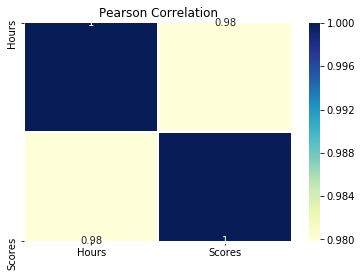

In [9]:
corr_matrix = df_train.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, fmt='.3g',
           cmap='YlGnBu', cbar=True, linewidths=1)
plt.title('Pearson Correlation')

## Model Design

To build the machine learning model by using a simple linear regression and compare the linear regressing by k-fold cross-calidation, a procedure that consists in splitting the data k times into train and validation sets and for each split, the model is trained and tested.

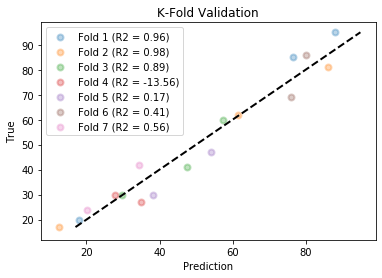

In [10]:
X = df_train.drop('Scores', axis=1).values
y = df_train['Scores'].values
feature_names = df_train.drop('Scores', axis=1).columns

X_names = ['Hours']

X_train = df_train[X_names].values
y_train = df_train['Scores'].values

X_test = df_test[X_names].values
y_test = df_test['Scores'].values

## call model
model = linear_model.LinearRegression()

## K fold validation
scores = []
cv = model_selection.KFold(n_splits=7, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                          y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' %(i,score))
    i = i+1
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)],
        ls='--', lw=2, color='black')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

The linear regression model presents better performances (average R squared of 0.94), so able to use it to predict test data.

In [11]:
## train
model.fit(X_train, y_train)

## test
predicted = model.predict(X_test)
predicted = scalerY.inverse_transform(
                    predicted.reshape(-1,1)).reshape(-1)

## Evaluation

To evaluate the model using the following common metrics: R squared, mean absolute error (MAE), and root mean squared error (RMSD). The last two are measures of error between paired observations expressing the same phenomenon.

In [12]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test - predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", 
      "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))

## residuals
residuals = y_test-predicted
max_error = max(residuals) if abs(max(residuals))> abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): -10278.0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.98
Mean Absolute Error (Σ|y-pred|/n): 2,241
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 2,413
Max Error: -3,613


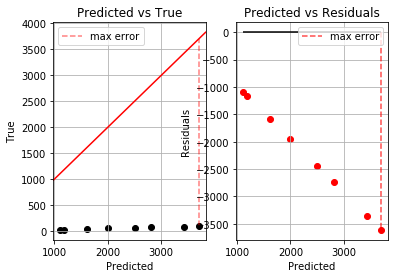

In [13]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color="red", ls="--", alpha=0.5, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()

## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color="red",
            ls="--", alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

The approximately distribution of the normal residuals

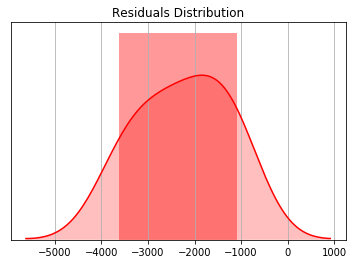

In [14]:
fig, ax = plt.subplots()
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True})
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals Distribution")
plt.show()

## Explainability 

Explainer give an illustration to take a random observation from the test set and see what the model predicts.

In [15]:
print("True:", "{:,.0f}".format(y_test[1]), "--> Pred:", "{:,.0f}".format(predicted[1]))

True: 54 --> Pred: 2,001


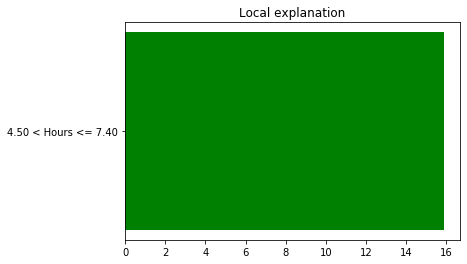

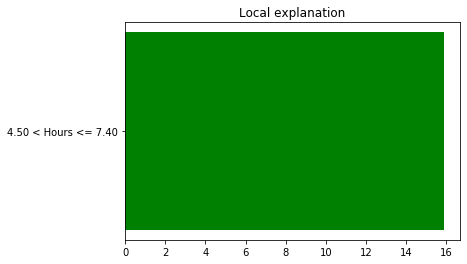

In [16]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=X_names,
                                             class_names="Scores", mode="regression")
explained = explainer.explain_instance(X_test[1], model.predict, num_features=1)
explained.as_pyplot_figure()

The main factors for this particular prediction is that the hours has a range between 3.8 and 6.90

## Task's Question
What will be predicted score if a student studies for 9.25 hrs/ day?

In [17]:
score_prediction = np.array([[9.25]])
pred = model.predict(score_prediction)
print(pred)

[94.3207181]


The student who studies 9.25 per day will likely to get around 94% score.